# Assignment 7.1 - Viola & Jones 

Welcome to the assignment for week 7.

#### Please state both names of your group members here:
Jane and John Doe

In [1]:
# Paola Gega, Daniel Thompson

---

## Grading Info/Details - Assignment 7.1:

The assignment will be graded semi-automatically, which means that your code will be tested against a set of predefined test cases and qualitatively assessed by a human. This will speed up the grading process for us.

* For passing the test scripts: 
    - Please make sure to **NOT** alter predefined class or function names, as this would lead to failing of the test scripts.
    - Please do **NOT** rename the files before uploading to the Whiteboard!

* **(RESULT)** tags indicate checkpoints that will be specifically assessed by a human.

* You will pass the assignment if you pass the majority of test cases and we can at least confirm effort regarding the **(RESULT)**-tagged checkpoints per task.

---

## Task 7.1.1: Rectangular Features

* Implement the construction of all 2-rect features (horizontal and vertical) within a given window (like the 24x24 px window from the paper)
* How many exist? **(RESULT)** 
* Display three of these overlaid onto an image of a face. **(RESULT)**

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform
# from tqdm.notebook import tqdm

In [3]:
# Implement the construction of all 2-rect features (horizontal and vertical) within a given window
def compute_2rects(window_size):
    """
    Generates 2-rect features with congruent rectangles (same width and height)
    for a given window size.
    
    Args:
        window_size (tuple): A tuple (width, height) representing the size of the window.
    Returns:
        list: A list of 2-rect features, each represented as a tuple of rectangles
        where each rectangle is defined by (x, y, width, height).
    """
    features = []
    window_width, window_height = window_size

    # Horizontal 2-rect features
    for rect_height in range(1, window_height + 1):
        for rect_width in range(1, window_width // 2 + 1):
            for y in range(0, window_height - rect_height + 1):
                for x in range(0, window_width - 2 * rect_width + 1):
                    rect1 = (x, y, rect_width, rect_height)
                    rect2 = (x + rect_width, y, rect_width, rect_height)
                    features.append((rect1, rect2))

    # Vertical 2-rect features
    for rect_width in range(1, window_width + 1):
        for rect_height in range(1, window_height // 2 + 1):
            for y in range(0, window_height - 2 * rect_height + 1):
                for x in range(0, window_width - rect_width + 1):
                    rect1 = (x, y, rect_width, rect_height)
                    rect2 = (x, y + rect_height, rect_width, rect_height)
                    features.append((rect1, rect2))

    return features

In [4]:
# Display three 2-rects overlaid onto an image of a face
def display_2rects(image, features, window_size):
    window_width, window_height = window_size
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        ax = axes[i]
        ax.imshow(image, cmap='gray')

        # Draw a random window within the image
        y = np.random.randint(0, image.shape[0] - window_height)
        x = np.random.randint(0, image.shape[1] - window_width)
        rect = plt.Rectangle((x, y), window_width, window_height, edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)

        # Draw the 2-rect feature
        rect1, rect2 = features[np.random.randint(len(features))]
        rect1_patch = plt.Rectangle((x + rect1[0], y + rect1[1]), rect1[2], rect1[3], edgecolor='blue', facecolor='none', linewidth=2)
        rect2_patch = plt.Rectangle((x + rect2[0], y + rect2[1]), rect2[2], rect2[3], edgecolor='green', facecolor='none', linewidth=2)
        ax.add_patch(rect1_patch)
        ax.add_patch(rect2_patch)

        ax.set_title(f'2-Rect {i+1}')
    plt.show()

In [5]:
window_size = (16, 16)
features = compute_2rects(window_size)
len(features)

17408

**Report:** There exist 17408 2-rect features in a window of size 16x16 px.

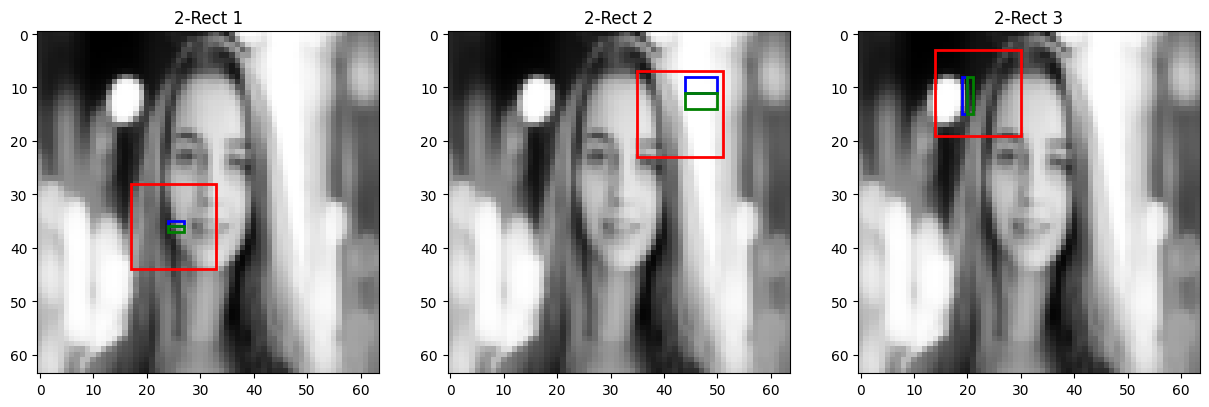

In [6]:
image = io.imread('./Harajuku_Fashion_Street_Snap_(October_09,_2017)_(32774966728).jpg')
gray_image = color.rgb2gray(image)
resized_image = transform.resize(gray_image, (64, 64))
display_2rects(resized_image, features, window_size)

## Task 7.1.2: Integral Image

* Implement a function that computes the integral image of a given input image. Display the integral image for an input of you choice **(RESULT)**. 
* Compare it to the output of skimage's integral_image() function. **(RESULT)**

In [7]:
def compute_integral_image(image):
    integral_image = np.cumsum(np.cumsum(image, axis=0), axis=1)
    return integral_image

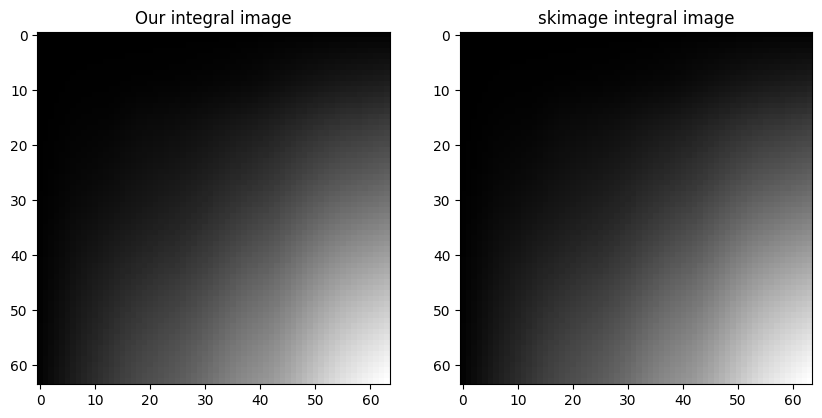

Frobenius norm of the difference: 0.0000000000


In [8]:
integral_image = compute_integral_image(resized_image)
integral_image_skimage = transform.integral_image(resized_image)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(integral_image, cmap='gray')
axs[0].set_title('Our integral image')
axs[1].imshow(integral_image_skimage, cmap='gray')
axs[1].set_title('skimage integral image')
plt.show()

print(f"Frobenius norm of the difference: {np.linalg.norm(integral_image - integral_image_skimage):.10f}")

**Report:** Our results are the same within numerical precision!

## Task 7.1.3: One Weak Classifier

* Implement a weak classifier that uses a single rectangular feature to classify an image as face/non-face. The classifier should take as input the integral image, the feature type, position, size, and threshold. It should output 1 for face, and 0 for non-face predictions. **(RESULT)**
* Test your weak classifier on an example image of your choice. **(RESULT)**

Suggestion: Use one cifar image as non-face and one tinyface image as face.

In [9]:
# Prepare tinyface data
import os
import shutil
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

def move_files_to_parent(parent_dir):
    for root, dirs, files in os.walk(parent_dir, topdown=False):
        # Move files in subdirectories to the parent directory
        for file in files:
            src = os.path.join(root, file)
            dst = os.path.join(parent_dir, file)
            shutil.move(src, dst)
        
        # Remove empty subdirectories
        for directory in dirs:
            subdir = os.path.join(root, directory)
            if not os.listdir(subdir):  # Check if the directory is empty
                os.rmdir(subdir)

# path = 'tinyface/Training_Set/'
# move_files_to_parent(path)

In [10]:
class TinyFace(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        Args:
            image_dir (str): Path to the directory with all images.
            transform (callable, optional): Optional transform to apply to the images.
        """
        self.image_dir = img_dir
        self.image_filenames = [
            f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the image to retrieve.
        
        Returns:
            image: Transformed image.
            label: Label (optional, could be derived from filenames if needed).
        """
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")  # Ensure 3-channel RGB
        if self.transform:
            image = self.transform(image)
        label = 1
        return (image, label)

# Define the transforms for preprocessing
transform = transforms.Compose([
    transforms.Resize((24, 24)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Create the dataset
tinyface_dataset = TinyFace(img_dir='tinyface/Training_Set', transform=transform)

# Access a single sample
image, label = tinyface_dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")
print(len(tinyface_dataset))

Image shape: torch.Size([1, 24, 24]), Label: 1
7804


In [11]:
# Face Data samples done
# Now loading CIFAR-10 dataset as non-face data and prepping it similarly

In [12]:
# Load CIFAR-10 dataset as non-face data

import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((24, 24)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

cifar10_train = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

cifar10_test = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Setting all targets to 0 (non-face)
cifar10_train.targets = [0] * len(cifar10_train)
cifar10_test.targets = [0] * len(cifar10_test)

# Access samples
image, label = cifar10_train[0]
print(f"Image shape: {image.shape}, Label: {label}")

Image shape: torch.Size([1, 24, 24]), Label: 0


In [13]:
def weak_classifier(integral_image, feature, threshold, feature_type=2):
    """
    Weak classifier using a single rectangular feature.
    
    Args:
        integral_image (numpy.ndarray): The integral image of the input image.
        feature (tuple): A tuple defining the feature (rect1, rect2) where each rect is (x, y, width, height).
        threshold (float): The threshold for classification.
    
    Returns:
        int: 1 for face, 0 for non-face.
    """
    if feature_type != 2:
        raise NotImplementedError(f"Feature type not implemented: {feature_type}-rect")
    rect1, rect2 = feature
    
    def rect_sum(integral_img, rect):
        x, y, w, h = rect
        A = integral_img[y - 1, x - 1] if x > 0 and y > 0 else 0
        B = integral_img[y - 1, x + w - 1] if y > 0 else 0
        C = integral_img[y + h - 1, x - 1] if x > 0 else 0
        D = integral_img[y + h - 1, x + w - 1]
        return D - B - C + A

    white_sum = rect_sum(integral_image, rect1)
    black_sum = rect_sum(integral_image, rect2)
    feature_value = black_sum - white_sum

    return 1 if feature_value >= threshold else 0

In [14]:
# Draw a random window within the image and test weak classifier on a random 2-rect feature within that window
y = np.random.randint(0, resized_image.shape[0] - 16)
x = np.random.randint(0, resized_image.shape[1] - 16)
n = np.random.randint(17408)
weak_classifier(integral_image[x:x+16,y:y+16], feature=features[n], threshold=0.5)

0

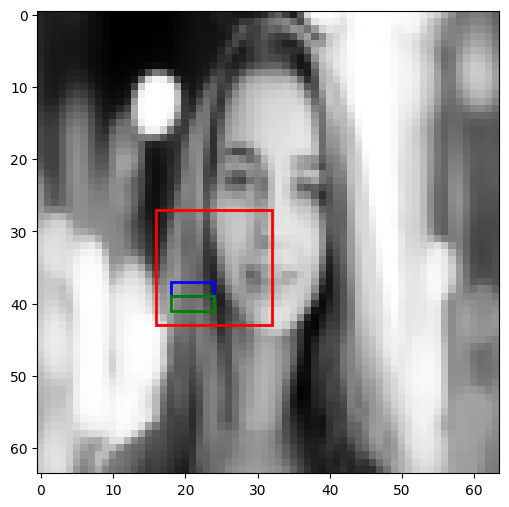

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(resized_image, cmap='gray')
rect = plt.Rectangle((x, y), 16, 16, edgecolor='red', facecolor='none', linewidth=2)
ax.add_patch(rect)

rect1, rect2 = features[n]
rect1_patch = plt.Rectangle((x + rect1[0], y + rect1[1]), rect1[2], rect1[3], edgecolor='blue', facecolor='none', linewidth=2)
rect2_patch = plt.Rectangle((x + rect2[0], y + rect2[1]), rect2[2], rect2[3], edgecolor='green', facecolor='none', linewidth=2)
ax.add_patch(rect1_patch)
ax.add_patch(rect2_patch)
plt.show()

## Task 7.1.4: AdaBoosting (BONUS)

* Implement the AdaBoost algorithm as outlined in the paper (https://www.face-rec.org/algorithms/Boosting-Ensemble/16981346.pdf).
* Train a 20-feature classifier using these datasets:
    - TinyFace for low resolution face images: https://qmul-tinyface.github.io/
    - CIFAR10 for negative samples: https://www.cs.toronto.edu/~kriz/cifar.html
* Test your classifier and report the results for different thresholds **(RESULTS)**

Suggestion: Use torch.utils.data.ConcatDataset to finalize the dataset. If you are more comfortable with numpy or another framework feel free to convert the data accordingly. <br><br>
Example conversion from torch.tensor to numpy: `numpy_array = tensor.numpy()`

In [16]:
# First TODO: Combine datasets into one training and one test set
# Suggested: use torch.utils.data.ConcatDataset

In [17]:
# TODO: Implement here

## Congratz, you made it! :)